# Comparison between exact and extrapolated solution correction

The exact solution correction is evaluated as the solution $w^n_x \in V^f$ to

$$a(w^n, z) + \tau b(w^n, z) = a(w^{n-1}, z), \quad \forall z\in V^f,$$

with initial value $w^0_x = \lambda_x - \phi^{'}_x$. This has to be solved in each time step. As an attempt to decrease the computational complexity, one may note that this problem corresponds to a parabolic problem without source term, whose solutions decays exponentially. For this purpose, this script assumes that 

$$w^1_x = e^{-\lambda t}w^0_x,$$

such that $\lambda$ is evaluated according to $\lambda = -\log(w^1_x/w^0_x)/\tau$. This script evaluates the exact corrections, as well as the approximated $w^n_x = e^{-n\tau \lambda} w^0_x$, and plots them next to each other for comparison reasons.

In [1]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from gridlod import util, fem, coef, interp
from gridlod.world import World
import lod_wave

'''
Settings
'''

# fine mesh parameters
fine = 256
NFine = np.array([fine])
NpFine = np.prod(NFine+1)
boundaryConditions = np.array([[0, 0]])
world = World(np.array([256]), NFine/np.array([256]), boundaryConditions)
NWorldFine = world.NWorldCoarse * world.NCoarseElement

# fine grid elements and nodes
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

# time step parameters
tau = 0.01
numTimeSteps = 100

# ms coefficients
epsA = 2 ** (-5)
epsB = 2 ** (-5)
aFine = (2 - np.sin(2 * np.pi * xt / epsA)) ** (-1)
bFine = (2 - np.cos(2 * np.pi * xt / epsB)) ** (-1)

k_0 = np.inf
k_1 = np.inf
N = 16

# coarse mesh parameters
NWorldCoarse = np.array([N])
NCoarseElement = NFine / NWorldCoarse
world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

# grid nodes
xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
NpCoarse = np.prod(NWorldCoarse + 1)

'''
Compute multiscale basis
'''

# patch generator and coefficients
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                              NCoarseElement, boundaryConditions)
b_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, bFine)
a_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, aFine / tau)

# compute basis correctors
lod = lod_wave.LodWave(b_coef, world, k_0, IPatchGenerator, a_coef)
lod.compute_basis_correctors()

# compute ms basis
basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
basis_correctors = lod.assembleBasisCorrectors()
ms_basis = basis - basis_correctors

'''
Compute finescale system

fs_solutions[i] = {w^i_x}_x
'''

prev_fs_sol = ms_basis
fs_solutions = []
for i in xrange(numTimeSteps):

    # solve system
    lod = lod_wave.LodWave(b_coef, world, k_1, IPatchGenerator, a_coef, prev_fs_sol, ms_basis)
    lod.solve_fs_system(localized=False)

    # store sparse solution
    prev_fs_sol = sparse.csc_matrix(np.array(np.column_stack(lod.fs_list)))
    fs_solutions.append(prev_fs_sol)

# Evaluate the set of lambdas

Might result in a RuntimeWarning due to the input of zeros into the log-function. However, numpy.nan_to_num() solves this issue such that these are converted to zeros in the set of $\lambda's$.

In [2]:
lams = np.log(fs_solutions[1]/fs_solutions[0])/(-1*tau)
lams = np.nan_to_num(lams)
lams = np.array(lams)
lams[lams > 5] = 5
lams[lams < 0.01] = 0.01

exp_fs_solutions = []
for i in range(numTimeSteps):
    exp_fs_solutions.append(sparse.csc_matrix(fs_solutions[0].toarray() * np.exp(-i * tau * lams)))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


# Plot the comparison at different times

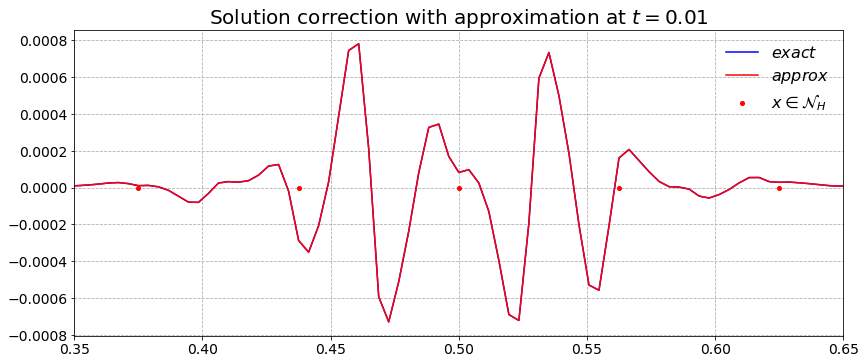

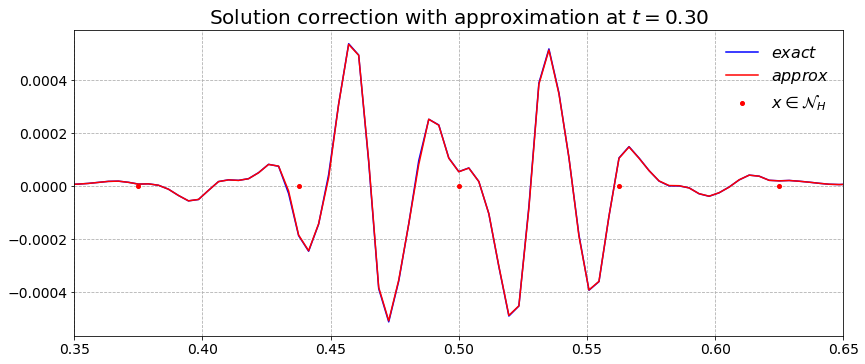

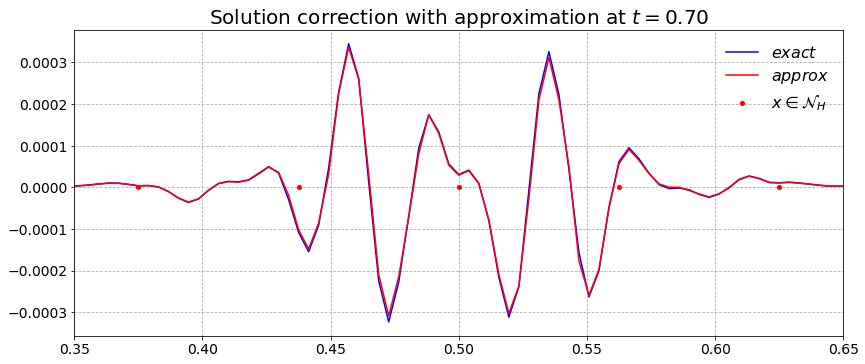

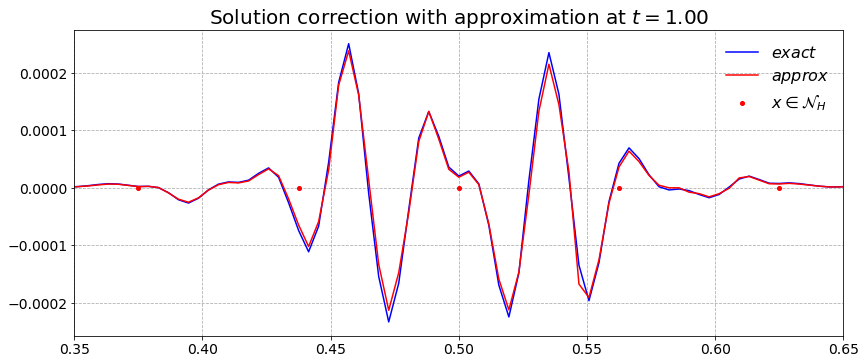

In [12]:
n_list = [0, 29, 69, 99]
x = N/2
for n in n_list:
    plt.figure('Correction', figsize=(12,5))
    plt.subplots_adjust(left=0.1, bottom=0.07, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
    plt.tick_params(labelsize=14)
    plt.xlim(0.35, 0.65)
    plt.plot(xp, fs_solutions[n][:,x].todense(), 'b', label='$exact$', linewidth=1.5)
    plt.plot(xp, exp_fs_solutions[n][:,x].todense(), 'r', label='$approx$', linewidth=1.5)
    plt.plot(xpCoarse, 0 * xpCoarse, 'or', label='$x\in \mathcal{N}_H$', markersize=4)
    plt.title('Solution correction with approximation at $t=%.2f$' %((n + 1) * tau), fontsize=20)
    plt.grid(True, which="both", ls="--")
    plt.legend(frameon=False, fontsize=16)
    plt.show()